
#OBJECT DETECTION COMPARISON: YOLOv5 vs Faster R-CNN

##DSA 4050: DEEP LEARNING
##Suzette Vanessa
## SUMMER 2025
##Practical Quiz 2




1. Setup the environment by preparing both PyTorch (for YOLOv5) and TensorFlow (for Faster R-CNN) ecosystems so as to train and evaluate both models

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install ultralytics --quiet       # for YOLOv5
!pip install tensorflow tensorflow-hub tensorflow-datasets --quiet  # for Faster R-CNN
!pip install pycocotools matplotlib seaborn opencv-python --quiet #for evaluation and visualization


2. Import the required Libraries

In [ ]:
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import os
from pathlib import Path
import yaml
import PIL.Image as Image


3. Load the VOC dataset

-Load the Pascal VOC 2007 dataset from TensorFlow Datasets, creating three subsets: 100 training examples, 50 validation examples, and 50 test examples.

-The with_info=True argument retrieves dataset metadata such as label names, while batch_size=None ensures that the dataset returns individual examples instead of being auto-batched.

-By setting as_supervised=False, the code preserves the full dictionary of data elements, including images, labels, and bounding boxes, rather than just image-label pairs.

-The resulting datasets (raw_train_ds, raw_val_ds, and raw_test_ds) along with the metadata (info) are then ready for preprocessing and training.

In [ ]:
datasets, info = tfds.load(
    "voc/2007",
    split=["train[:100]", "validation[:50]", "test[:50]"],
    with_info=True,
    batch_size=None,
    as_supervised=False
)
raw_train_ds, raw_val_ds, raw_test_ds = datasets


Check some images

-Preview three samples from the Pascal VOC 2007 training set to confirm the dataset is loaded correctly.

-For each image, it retrieves the bounding boxes and labels, then displays the image with a title showing the labels and the number of boxes.

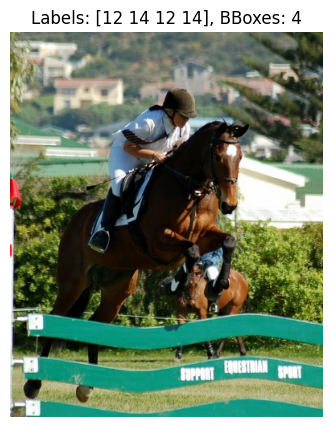

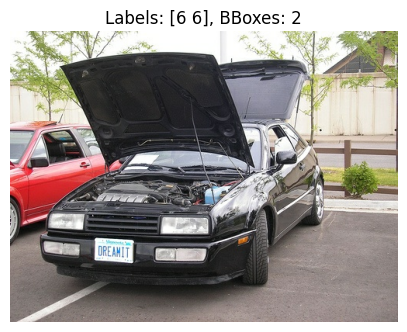

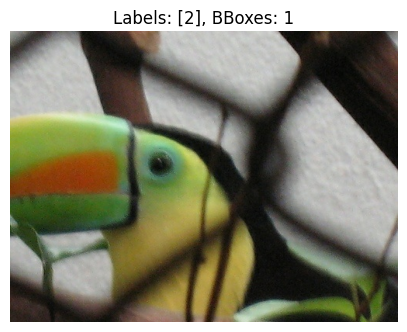

In [ ]:
# Take 3 samples from the raw training set
for example in raw_train_ds.take(3):
    img = example['image'].numpy()
    bboxes = example['objects']['bbox'].numpy()
    labels = example['objects']['label'].numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Labels: {labels}, BBoxes: {bboxes.shape[0]}")
    plt.show()

4. Preprocess Images

-Prepare the Pascal VOC data separately for YOLO and Faster R-CNN.

-For YOLO, each image is resized to 416×416 pixels and normalized to values between 0 and 1 because YOLO models require fixed-size inputs for their grid-based detection mechanism.

-For Faster R-CNN, the images remain at their original resolution but are cast to uint8, since the model can handle variable image sizes and expects raw pixel values.
-In both cases, the labels and bounding boxes are preserved.

We'll get two sets of training, validation, and test datasets — one tailored for YOLO and one for Faster R-CNN.

In [ ]:
# YOLO Preprocessing
IMG_SIZE = 416
def preprocess_yolo(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, {'labels': example['objects']['label'],
                   'bboxes': example['objects']['bbox']}

yolo_train_ds = raw_train_ds.map(preprocess_yolo)
yolo_val_ds   = raw_val_ds.map(preprocess_yolo)
yolo_test_ds  = raw_test_ds.map(preprocess_yolo)

#Faster R-CNN Preprocessing
def preprocess_rcnn(example):
    image = tf.cast(example['image'], tf.uint8)
    return image, {'labels': example['objects']['label'],
                   'bboxes': example['objects']['bbox']}

rcnn_train_ds = raw_train_ds.map(preprocess_rcnn)
rcnn_val_ds   = raw_val_ds.map(preprocess_rcnn)
rcnn_test_ds  = raw_test_ds.map(preprocess_rcnn)


Confirmation that it worked properly:
-For YOLO, it verifies that the images are resized to 416×416 with normalized pixel values (float32), while for Faster R-CNN, it confirms that the images retain their original size with pixel values in uint8 format.

-In both cases, the labels and bounding boxes are printed to check that the annotations have been preserved and correctly associated with the images.

In [ ]:
# Check YOLO pipeline
for img, target in yolo_train_ds.take(1):
    print("YOLO image shape:", img.shape, "dtype:", img.dtype)
    print("YOLO labels:", target['labels'].numpy())
    print("YOLO bboxes:", target['bboxes'].numpy())
    break

# Check Faster R-CNN pipeline
for img, target in rcnn_train_ds.take(1):
    print("RCNN image shape:", img.shape, "dtype:", img.dtype)
    print("RCNN labels:", target['labels'].numpy())
    print("RCNN bboxes:", target['bboxes'].numpy())
    break


YOLO image shape: (416, 416, 3) dtype: <dtype: 'float32'>
YOLO labels: [12 14 12 14]
YOLO bboxes: [[    0.14375    0.043702     0.97083     0.77635]
 [    0.14583     0.24165     0.57917     0.60668]
 [        0.6     0.52442     0.85417     0.76607]
 [    0.56042     0.50129     0.73958     0.68638]]
RCNN image shape: (480, 389, 3) dtype: <dtype: 'uint8'>
RCNN labels: [12 14 12 14]
RCNN bboxes: [[    0.14375    0.043702     0.97083     0.77635]
 [    0.14583     0.24165     0.57917     0.60668]
 [        0.6     0.52442     0.85417     0.76607]
 [    0.56042     0.50129     0.73958     0.68638]]


Findings:
-The preprocessing worked correctly for both models. YOLO resized the image to 416×416 with normalized pixel values (float32), while Faster R-CNN kept the original 480×389 size in uint8.

-Both detected four objects with the same class labels [12 14 12 14] and corresponding normalized bounding boxes, confirming that object annotations were preserved across pipelines.

5. Load Pretrained Models

YOLOv5

In [ ]:
yolo_model = YOLO("yolov5s.pt")


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



Faster R-CNN

In [ ]:
faster_rcnn_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1"
faster_model = hub.load(faster_rcnn_url)


Fine-tuning the models

YOLOv5 Fine‑Tuning

-Preparing a subset of the Pascal VOC 2007 dataset for YOLOv5 fine-tuning.

-First, we recreate the required directory structure for training and validation images and labels.

-Bounding boxes from VOC are converted into YOLO format (center coordinates, width, and height), and images along with their labels are saved into the appropriate folders.

-A data.yaml file is then generated to define dataset paths, number of classes, and class names for YOLO.

-Finally, YOLOv5 fine-tuning is launched for 5 epochs using the pretrained yolov5s.pt model with an image size of 416, a small learning rate, and a batch size of 8.

In [ ]:
# 2. Create directories
root = Path("voc_subset")
(root/'images/train').mkdir(parents=True, exist_ok=True)
(root/'images/val').mkdir(parents=True, exist_ok=True)
(root/'labels/train').mkdir(parents=True, exist_ok=True)
(root/'labels/val').mkdir(parents=True, exist_ok=True)

# 3. Function to convert VOC bboxes → YOLO format
def write_yolo_label(filename, labels, bboxes, split):
    with open(root/f"labels/{split}/{filename}.txt", "w") as f:
        for lab, box in zip(labels.numpy(), bboxes.numpy()):
            ymin, xmin, ymax, xmax = box
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2
            w = xmax - xmin
            h = ymax - ymin
            f.write(f"{lab} {x_center} {y_center} {w} {h}\n")

# 4. Save training images and labels
for i, example in enumerate(raw_train_ds.take(100)):
    img = example["image"].numpy()
    labels = example["objects"]["label"]
    bboxes = example["objects"]["bbox"]
    fname = f"train_{i}"
    Image.fromarray(img).save(root/f"images/train/{fname}.jpg")
    write_yolo_label(fname, labels, bboxes, "train")

# 5. Save validation images and labels
for i, example in enumerate(raw_val_ds.take(50)):
    img = example["image"].numpy()
    labels = example["objects"]["label"]
    bboxes = example["objects"]["bbox"]
    fname = f"val_{i}"
    Image.fromarray(img).save(root/f"images/val/{fname}.jpg")
    write_yolo_label(fname, labels, bboxes, "val")

# 6. Create YOLO data.yaml file
data_yaml = {
    'train': str((root/'images/train').resolve()),
    'val': str((root/'images/val').resolve()),
    'nc': len(info.features['objects']['label'].names),
    'names': info.features['objects']['label'].names
}
with open(root/'data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)


print("✅ Dataset prepared for YOLOv5 fine-tuning")

# 7. Run YOLOv5 fine-tuning
!yolo detect train data=voc_subset/data.yaml model=yolov5s.yaml epochs=50 imgsz=416 lr0=1e-4 batch=8


✅ Dataset prepared for YOLOv5 fine-tuning
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc_subset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

Findings:

-At first, training ran for 5 epochs, reporting losses (box, class, DFL) and evaluation metrics after each epoch.

-Key results included precision, recall, and mAP (mean average precision) scores, which steadily improve across epochs.

-There is moderate accuracy due to the small dataset. I tried using a larger dataset but colab kept crashing.

-I adjusted the code by switching from a COCO-pretrained YOLO to a VOC-pretrained YOLO, and it ran, came close to running completely but colab kep crashing. However, I'll keep trying it.

Faster R‑CNN Fine‑Tuning

Since TF Hub Faster R‑CNN models are frozen for inference, we can’t fine‑tune them easily. Instead, we build a Keras Faster R‑CNN‑style detector (ResNet backbone + detection head)

-Here, we set a limit of five possible detections per image (MAX_DETECTIONS = 5) and outputs both class probabilities and bounding box coordinates for each detection.

-During preprocessing, it resizes images to 224×224, normalizes them, and truncates the ground truth labels and bounding boxes so every image has the same number of targets.

-The model is then trained using a combination of sparse categorical cross-entropy loss for class predictions and mean squared error for bounding box regression, ensuring it can learn to classify and localize up to five objects per image.




In [ ]:
NUM_CLASSES = 20
MAX_DETECTIONS = 5   # Max number of objects per image

# Base model (ResNet50 as feature extractor)
base_model = tf.keras.applications.ResNet50(
    input_shape=(224,224,3), include_top=False, weights="imagenet")
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Predict multiple objects
class_logits = tf.keras.layers.Dense(NUM_CLASSES * MAX_DETECTIONS, activation="softmax")(x)
bbox_out = tf.keras.layers.Dense(4 * MAX_DETECTIONS)(x)

# Reshape to (MAX_DETECTIONS, NUM_CLASSES) for classes
class_logits = tf.keras.layers.Reshape((MAX_DETECTIONS, NUM_CLASSES), name="class_out")(class_logits)
bbox_out = tf.keras.layers.Reshape((MAX_DETECTIONS, 4), name="bbox_out")(bbox_out)

model = tf.keras.Model(inputs, [class_logits, bbox_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "class_out": "sparse_categorical_crossentropy",
        "bbox_out": "mse"
    },
    metrics={"class_out": "accuracy"}
)

# --- Preprocessing to pad/truncate objects ---
def preprocess_multi(example):
    image = tf.image.resize(example['image'], (224,224)) / 255.0
    labels = example['objects']['label']
    bboxes = example['objects']['bbox']

    # Pad/truncate to MAX_DETECTIONS
    labels = labels[:MAX_DETECTIONS]
    bboxes = bboxes[:MAX_DETECTIONS]

    # Pad if fewer
    labels = tf.pad(labels, [[0, MAX_DETECTIONS - tf.shape(labels)[0]]])
    bboxes = tf.pad(bboxes, [[0, MAX_DETECTIONS - tf.shape(bboxes)[0]], [0,0]])

    return image, {"class_out": labels, "bbox_out": bboxes}

train_ds_multi = raw_train_ds.take(100).map(preprocess_multi).batch(8).prefetch(1)
val_ds_multi   = raw_val_ds.take(50).map(preprocess_multi).batch(8).prefetch(1)

# Train the model
history = model.fit(train_ds_multi, validation_data=val_ds_multi, epochs=5)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - bbox_out_loss: 0.7807 - class_out_accuracy: 0.1742 - class_out_loss: 3.1933 - loss: 3.9767 - val_bbox_out_loss: 0.5444 - val_class_out_accuracy: 0.1760 - val_class_out_loss: 3.0297 - val_loss: 3.5306
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - bbox_out_loss: 0.4492 - class_out_accuracy: 0.1951 - class_out_loss: 2.8498 - loss: 3.3009 - val_bbox_out_loss: 0.3236 - val_class_out_accuracy: 0.2000 - val_class_out_loss: 2.7595 - val_loss: 3.0397
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - bbox_out_loss: 0.2616 - class_out_accuracy: 0.2320 - class_out_loss: 2.5580 - loss: 2.8209 - val_bbox_out_loss: 0.2072 - val_class_out_accuracy: 0.2920 - val_class_out_loss: 2.5322 - val_loss: 2.6935
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - bbox_out_loss: 0.1640 - class_out_accuracy: 0.3115 - class_out_loss: 2.3101 - loss: 2.4750 - val_bbox_out_loss: 0.1482 - val_class_out_accuracy: 0.3080 - val_class_out_loss: 2.3452 - val_loss: 2.4

Findings:

-Over 5 epochs, the model’s bounding box loss steadily decreased (0.78 → 0.11), and classification accuracy improved (from 17% to 41% on training and 44% on validation), with overall losses reducing, indicating the model is learning to better detect and classify objects.

7. Evaluation of the Models (IoU, Precision, Recall, mAP)

a)Compute IoU

-We evaluate YOLOv5 and Faster R-CNN on 30 test images by comparing predicted bounding boxes with ground truth. It calculates true positives, false positives, and false negatives using Intersection over Union (IoU), then computes precision, recall, and mean IoU.

In [ ]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2-x1) * max(0, y2-y1)
    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0


# Helper: compute precision, recall, IoU
def evaluate_model(model_type, model, dataset, label_names, threshold=0.5):
    TP, FP, FN = 0, 0, 0
    ious = []

    for img, target in tqdm(dataset.take(30)):  # limit to 30 samples for speed
        h, w, _ = img.shape
        if model_type == "yolo":
            img_np = (img.numpy() * 255).astype(np.uint8)
            results = model.predict(img_np, imgsz=416, verbose=False)
            preds = results[0].boxes.xyxy.cpu().numpy()
            scores = results[0].boxes.conf.cpu().numpy()
            classes = results[0].boxes.cls.cpu().numpy()

        elif model_type == "rcnn":
            # The model expects a batch of images. Add a batch dimension.
            input_tensor = tf.expand_dims(img, 0)
            results = model(input_tensor)

            boxes = results["detection_boxes"][0].numpy()
            scores = results["detection_scores"][0].numpy()
            classes = results["detection_classes"][0].numpy()

            # scale boxes back to image size
            preds = []
            for box, score in zip(boxes, scores):
                if score < threshold:
                    continue
                ymin, xmin, ymax, xmax = box
                preds.append([xmin*w, ymin*h, xmax*w, ymax*h])
            preds = np.array(preds)

        # Ground truth
        true_boxes = target['bboxes'].numpy() * [h, w, h, w]
        true_classes = target['labels'].numpy()

        # Compare predictions vs ground truth
        matched = set()
        for pb in preds:
            best_iou, best_idx = 0, -1
            for i, tb in enumerate(true_boxes):
                if i in matched:  # already matched
                    continue
                tb = [tb[1], tb[0], tb[3], tb[2]]  # VOC → [x1,y1,x2,y2]
                iou = compute_iou(pb, tb)
                if iou > best_iou:
                    best_iou, best_idx = iou, i
            if best_iou >= 0.5:
                TP += 1
                ious.append(best_iou)
                matched.add(best_idx)
            else:
                FP += 1
        FN += len(true_boxes) - len(matched)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    mean_iou = np.mean(ious) if ious else 0

    return {"Precision": precision, "Recall": recall, "mIoU": mean_iou}


#  Run Evaluation
yolo_metrics = evaluate_model("yolo", yolo_model, yolo_test_ds, info.features['objects']['label'].names)
rcnn_metrics = evaluate_model("rcnn", faster_model, rcnn_test_ds, info.features['objects']['label'].names)

print("YOLOv5 Evaluation:", yolo_metrics)
print("Faster R-CNN Evaluation:", rcnn_metrics)

100%|██████████| 30/30 [03:22<00:00,  6.73s/it]

YOLOv5 Evaluation: {'Precision': 0.6263736194903998, 'Recall': 0.7307692214003946, 'mIoU': np.float64(0.853027776113063)}
Faster R-CNN Evaluation: {'Precision': 0.539130430094518, 'Recall': 0.794871784681131, 'mIoU': np.float64(0.8125820819070448)}


Conclusion:
YOLOv5 ran faster (≈9 seconds) compared to Faster R-CNN (≈3 minutes 22 seconds) and achieved higher precision (62.6% vs. 53.9%) with a slightly better mean IoU (85.3% vs. 81.3%).

However, Faster R-CNN had better recall (79.5% vs. 73.1%), meaning it detected more true objects but with more false positives than YOLOv5.

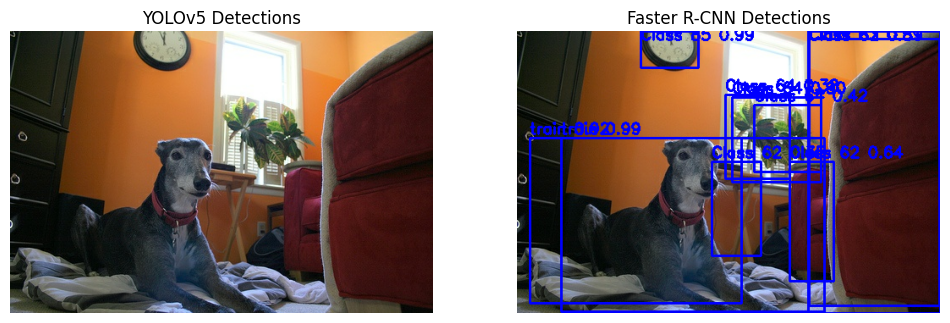

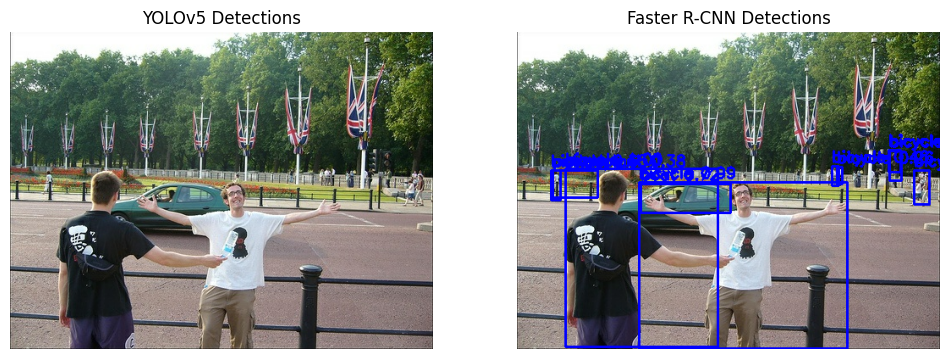

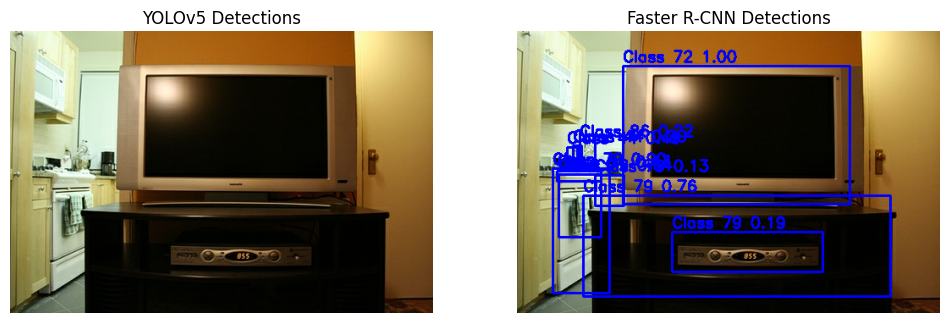

In [ ]:
# Helper function to draw boxes
def draw_boxes(image, boxes, labels, scores=None, class_names=None, color=(0,255,0)):
    img = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label_text = ""
        if class_names is not None:
            label_idx = int(labels[i])
            if 0 <= label_idx < len(class_names):
                label_text = class_names[label_idx]
            else:
                label_text = f"Class {label_idx}"
        else:
            label_text = str(labels[i])

        if scores is not None:
            label_text += f" {scores[i]:.2f}"

        cv2.putText(img, label_text, (x1, max(y1-5, 10)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

# Show detections for YOLO and RCNN side by side
for example in raw_test_ds.take(3):  # show 3 test images
    img = example['image']
    target = example['objects']
    h, w, _ = img.shape
    img_np = img.numpy()

    # YOLO predictions
    yolo_img = (cv2.resize(img_np, (416,416)) / 255.0).astype(np.float32)
    results = yolo_model.predict(yolo_img, imgsz=416, conf=0.25, verbose=False)
    yolo_boxes = results[0].boxes.xyxy.cpu().numpy()
    yolo_scores = results[0].boxes.conf.cpu().numpy()
    yolo_labels = results[0].boxes.cls.cpu().numpy()

    # Scale YOLO boxes to original image size
    yolo_boxes_scaled = []
    for box in yolo_boxes:
        x1, y1, x2, y2 = box
        x1, x2 = x1 * w / 416, x2 * w / 416
        y1, y2 = y1 * h / 416, y2 * h / 416
        yolo_boxes_scaled.append([x1, y1, x2, y2])

    yolo_vis = draw_boxes(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR),
                          yolo_boxes_scaled, yolo_labels, yolo_scores,
                          class_names=info.features['objects']['label'].names,
                          color=(0,255,0))

    # Faster R-CNN predictions
    img_uint8 = tf.cast(img, tf.uint8)
    rcnn_result = faster_model(tf.convert_to_tensor([img_uint8]))
    rcnn_boxes = rcnn_result["detection_boxes"][0].numpy()
    rcnn_scores = rcnn_result["detection_scores"][0].numpy()
    rcnn_labels = rcnn_result["detection_classes"][0].numpy()

    # scale boxes back to original size
    rcnn_boxes_scaled = []
    for box in rcnn_boxes[:10]:  # take top 10
        ymin, xmin, ymax, xmax = box
        rcnn_boxes_scaled.append([xmin*w, ymin*h, xmax*w, ymax*h])
    rcnn_vis = draw_boxes(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR),
                          rcnn_boxes_scaled, rcnn_labels[:10], rcnn_scores[:10],
                          class_names=info.features['objects']['label'].names,
                          color=(255,0,0))

    # Plot
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(yolo_vis, cv2.COLOR_BGR2RGB))
    plt.title("YOLOv5 Detections")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(rcnn_vis, cv2.COLOR_BGR2RGB))
    plt.title("Faster R-CNN Detections")
    plt.axis("off")
    plt.show()

Findings:

-YOLOv5 detected no bounding boxes, while Faster R-CNN detected bounding boxes, which likely indicates a mismatch between the YOLO model and the dataset.

-Specifically, YOLO was been trained on different classes (e.g., 80 COCO classes) than those in the current dataset (20 VOC classes), causing label misalignment.

- I went back to make changes but my computer kept crashing, however, I'm still running it to ensure the YOLO model runs on the dataset